In [285]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

import pattrex.plotting_mpl as plt_rex

# PCA

Referred to np-sp-recipes-12 (for eigenvalues/eigenvecotrs of covariance matrices)

## Import and Preprocess data

- Import data into a `numpy` array
- **normalize** the data to zero-mean

In [236]:
data_X_fp = "./data/data-dimred-X.csv"
data_y_fp = "./data/data-dimred-y.csv"

data_X = np.genfromtxt(data_X_fp, delimiter=',')
data_y = np.genfromtxt(data_y_fp, delimiter=',')

print("data : {} \nlabels : {}".format(data_X.shape, data_y.shape))

data : (500, 150) 
labels : (150,)


In [237]:
data_y

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.])

In [238]:
data_X_mean = data_X.mean()
data_X_norm = data_X - data_X_mean

data_X_norm.mean()

1.8947806286936004e-17

## Caculate the Covariance Matrix

In [239]:
C_X = np.cov(data_X_norm)
C_X.shape

(500, 500)

## Do Eigen Analysis

Using `numpy.linalg.eigh(...)`

(500,)
(500, 500)


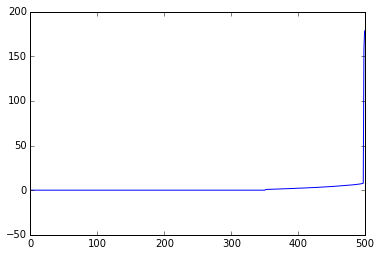

In [240]:
evals, evects = np.linalg.eigh(C_X)

print(evals.shape)
print(evects.shape)

plt.plot(np.arange(evals.size), evals)

In [241]:
dims = evals.shape[0]
print(dims)
print(evects[:, 0].shape)

for i in range(dims):
    evi = evects[:, i].reshape(dim, 1)
    print(i)
    np.testing.assert_array_almost_equal(C_X.dot(evi),
                                        evals_L[i] * evi)

500
(500,)
0


AssertionError: 
Arrays are not almost equal to 6 decimals

(mismatch 99.8%)
 x: array([[  1.054712e-15],
       [ -6.217249e-15],
       [ -4.440892e-16],...
 y: array([[ -0.000000e+00],
       [  4.198470e+18],
       [  4.870672e+17],...

### So, they are ascending
Let's look at the top 10

In [242]:
# sort descending
idx = np.argsort(evals)[::-1]
sorted_evals = evals[idx]
sorted_evects = evects[:, idx]

In [243]:
sorted_evals[:10]

array([ 178.36082561,  157.5026053 ,    7.76115581,    7.51579683,
          7.28021248,    7.18770618,    7.05327894,    6.87866945,
          6.8158655 ,    6.73649919])

### Let's try to find where do they sum up to 90, 95, and 99 % of the total

In [244]:
sum_s_evals = np.cumsum(sorted_evals)

def where_sum_to(X, x, side='left'):
    return np.searchsorted(X, x, side=side)

print("90%  :", where_sum_to(sum_s_evals, sum_s_evals[-1] * 0.9))
print("95%  :", where_sum_to(sum_s_evals, sum_s_evals[-1] * 0.95))
print("99%  :", where_sum_to(sum_s_evals, sum_s_evals[-1] * 0.99))
print("100% :", where_sum_to(sum_s_evals, sum_s_evals[-1] * 1.0), " First")
print("100% :", where_sum_to(sum_s_evals, sum_s_evals[-1] * 1.0, side='right'), " Last")

90%  : 94
95%  : 114
99%  : 139
100% : 148  First
100% : 500  Last


## Who Needs all of them???
Let's see how much the first two eigvals contribute

In [245]:
contrib = lambda i : 100 * sum_s_evals[i-1] / sum_s_evals[-1]

print("\n".join("First {} : {:.4} %".format(*p) for p in [(i, contrib(i)) for i in [1, 2, 3, 4, 5]]))

First 1 : 21.61 %
First 2 : 40.69 %
First 3 : 41.63 %
First 4 : 42.54 %
First 5 : 43.42 %


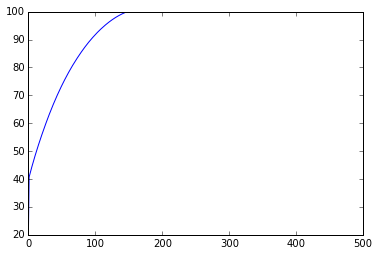

In [246]:
plt.plot([contrib(i + 1) for i in range(sum_s_evals.size)])

## Back to the task

- Choose the eigvecs corresponding to the first two (highest) eigvals
- Project the **normalized** data into $\mathbb{R}^2$
- Plot

In [247]:
eigval_2 = sorted_evals[:2]
eigvec_2 = sorted_evects[:, :2]

print(eigval_2)
print(eigvec_2.shape)

[ 178.36082561  157.5026053 ]
(500, 2)


In [248]:
projection = np.dot(data_X_norm.T, eigvec_2)

projection.shape

(150, 2)

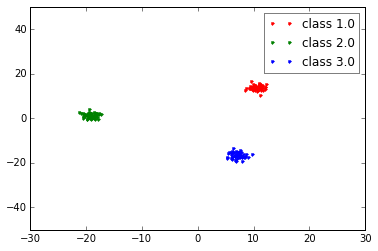

In [249]:
fig = plt.figure()
axs = fig.add_subplot(111)

for l, c in zip([1., 2., 3.], ['r.', 'g.', 'b.']):
    plt_rex.plot2d(projection[np.where(data_y == l)], False, axs=axs,
                  x_lim=[-30, 30], y_lim=[-50, 50], hatch=c, show=False,
                  plotlabel="class " + str(l))

### WooHoo

# Multiclass LDA

## Split the data based on class first

In [250]:
datas = {c : {"data" : np.copy(data_X[:, np.where(data_y == c)[0]])}
         for c in np.unique(data_y)}

In [251]:
print("\n".join("Class {} : dim {}, # {}".format(k, *v["data"].shape) 
                for k, v in datas.items()))

Class 1.0 : dim 500, # 50
Class 2.0 : dim 500, # 50
Class 3.0 : dim 500, # 50


## Calculate $S_W$, $S_B$

In [252]:
ddof = 0
for k, v in datas.items():
    datas[k]["mean"] = np.mean(v["data"], axis=1)
    datas[k]["cov"] = np.cov(v["data"], ddof=ddof)
    datas[k]["n"] = v["data"].shape[1]

datas[1.0]["cov"].shape

(500, 500)

In [253]:
S_w = sum([v["cov"] * (v["n"] - ddof) for v in datas.values()])
S_w.shape

(500, 500)

In [254]:
data_mean = np.mean(data_X, axis=1)
data_mean.shape

(500,)

In [187]:
np.allclose(data_mean - (1/150) * sum([50 * datas[c]["mean"] for c in datas.keys()]),
           np.zeros(500))

True

In [188]:
np.allclose(np.mean(np.vstack([datas[k]["mean"] for k in datas.keys()]), axis=0) - data_mean, np.zeros(500))

True

In [255]:
S_b = np.zeros(S_w.shape)
for v in datas.values():
    mean_diff = v["mean"] - data_mean
    mean_diff = mean_diff.reshape(mean_diff.shape[0], 1)
    S_b += v["n"] * mean_diff.dot(mean_diff.T)  # / v["n"]
    
S_b.shape

(500, 500)

In [200]:
S_t = np.cov(data_X)
np.testing.assert_array_almost_equal(S_b, S_t - S_w)

AssertionError: 
Arrays are not almost equal to 6 decimals

(mismatch 100.0%)
 x: array([[  46.771789,  -22.394256,   39.4934  , ...,   -2.109421,
         -29.786393,  -31.561474],
       [ -22.394256,   29.415908,   33.254963, ...,  -27.328055,...
 y: array([[-130.912725,   -3.112319,   -6.313061, ...,    3.688155,
          -5.493464,  -11.109758],
       [  -3.112319, -128.834601,  -15.153121, ...,   14.877384,...

In [256]:
evals_L, evects_L = np.linalg.eigh(np.linalg.inv(S_w).dot(S_b))

print(evals_L.shape, evects_L.shape)

(500,) (500, 500)


In [257]:
dims = evals_L.shape[0]

for i in range(dims):
    evi = evects_L[:, i].reshape(dim, 1)
    print(i)
    np.testing.assert_array_almost_equal(np.linalg.inv(S_w).dot(S_b).dot(evi),
                                        evals_L[i] * evi)

0


AssertionError: 
Arrays are not almost equal to 6 decimals

(mismatch 100.0%)
 x: array([[  7.175487e+17],
       [  1.562347e+16],
       [ -8.034747e+17],...
 y: array([[  2.681538e+17],
       [  7.818091e+16],
       [  7.985324e+17],...

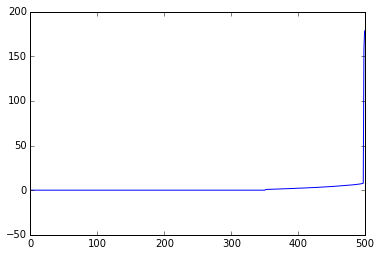

In [258]:
plt.plot(np.arange(evals_L.size), evals)

In [259]:
# sort descending
idx_L = np.argsort(evals_L)[::-1]
sorted_evals_L = evals_L[idx]
sorted_evects_L = evects_L[:, idx]

eigval_L_2 = sorted_evals_L[:2]
eigvec_L_2 = sorted_evects_L[:, :2]

print(eigval_L_2)
print(eigvec_L_2.shape)

[  9.76172857e+18   3.23052522e+18]
(500, 2)


In [260]:
projection_L = (data_X.T).dot(eigvec_L_2)

projection_L.shape

(150, 2)

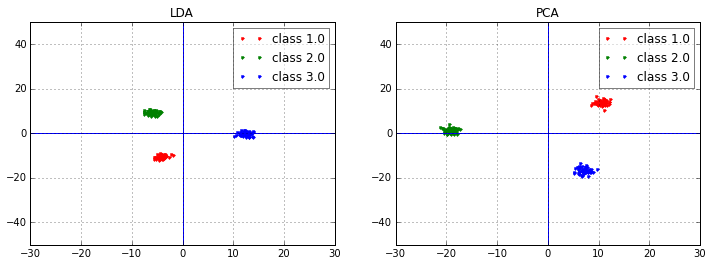

In [267]:
fig = plt.figure(figsize=(12, 4))
axs1 = fig.add_subplot(121)
axs2 = fig.add_subplot(122)

for l, c in zip([1., 2., 3.], ['r.', 'g.', 'b.']):
    plt_rex.plot2d(projection_L[np.where(data_y == l)], False, axs=axs1,
                  x_lim=[-30, 30], y_lim=[-50, 50], hatch=c, show=False,
                  plotlabel="class " + str(l), title="LDA")
    plt_rex.plot2d(projection[np.where(data_y == l)], False, axs=axs2,
                  x_lim=[-30, 30], y_lim=[-50, 50], hatch=c, show=False,
                  plotlabel="class " + str(l), title="PCA")
    
axs1.grid()
axs1.axvline(x=0)
axs1.axhline(y=0)

axs2.grid()
axs2.axvline(x=0)
axs2.axhline(y=0)

In [264]:
plt_rex.plot2d??

# In $\mathbb{R}^3$

In [268]:
eigval_L_3 = sorted_evals_L[:3]
eigvec_L_3 = sorted_evects_L[:, :3]

print(eigval_L_3)
print(eigvec_L_3.shape)

projection_L_3 = (data_X.T).dot(eigvec_L_3)

projection_L_3.shape

[  9.76172857e+18   3.23052522e+18   3.10432128e+18]
(500, 3)


(150, 3)

In [269]:
eigval_3 = sorted_evals[:3]
eigvec_3 = sorted_evects[:, :3]

print(eigval_3)
print(eigvec_3.shape)

projection_3 = (data_X.T).dot(eigvec_3)

projection_3.shape

[ 178.36082561  157.5026053     7.76115581]
(500, 3)


(150, 3)

<IPython.core.display.Javascript object>


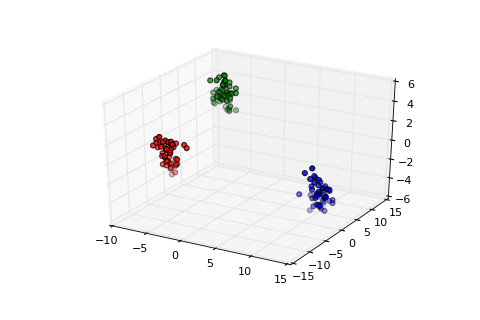

In [290]:
fig1 = plt.figure()
axs1 = plt.axes(projection='3d')


for l, c in zip([1., 2., 3.], ['r', 'g', 'b']):
    d_L = projection_L_3[np.where(data_y == l)]
    d = projection_3[np.where(data_y == l)]
    axs1.scatter3D(d_L[:, 0], d_L[:, 1], d_L[:, 2], c=c)
    
axs1.grid()

<IPython.core.display.Javascript object>


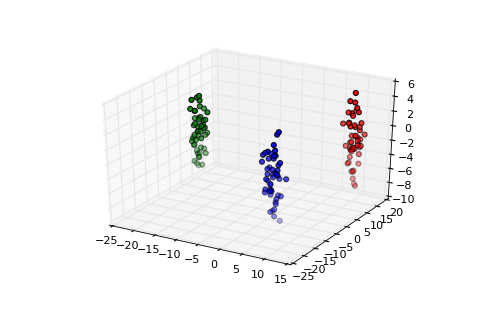

In [291]:
fig2 = plt.figure()
axs2 = plt.axes(projection='3d')

for l, c in zip([1., 2., 3.], ['r', 'g', 'b']):
    d = projection_3[np.where(data_y == l)]
    axs2.scatter3D(d[:, 0], d[:, 1], d[:, 2], c=c)

In [ ]:
fig3 = plt.figure()
axs3 = plt.axes(projection='3d')


for l, c in zip([1., 2., 3.], ['r', 'g', 'b']):
    d_L = projection_L[np.where(data_y == l)]
    d = projection_3[np.where(data_y == l)]
    axs3.scatter3D(d_L[:, 0], d_L[:, 1], d_L[:, 2], c=c)
    
axs3.grid()